<a href="https://colab.research.google.com/github/rameshnatarajanus/Sentinel-5p-NO2-data-analysis/blob/main/Notebooks/Earth_Engine_training_data_Sentinel5p.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Copyright 2023 Google LLC. { display-mode: "form" }
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Download training patches from Earth Engine

This demonstration shows how to get patches of Sentinel-5P images for Tropomi NO2 measurements from Earth Engine for training ML models.  

Specifically, we reduce the data to the daily images, and then  we use `computePixels` to extract the daily time series of image patches, and `reduceRegions` to obtain the daily time series of spatial-averaged statistics, over the region of specific interest.

In future, these calls are made in parallel to quickly and efficiently write a TFRecord file
for machine learning.

## Imports

In [1]:
from google.colab import auth
from google.api_core import retry
from IPython.display import HTML, Image
from matplotlib import pyplot as plt
from numpy.lib import recfunctions as rfn

import concurrent
import ee
import geemap
import google
import io
import multiprocessing
import numpy as np
import requests
import tensorflow as tf
import pandas as pd
import math


## Authentication and initialization

Use the Colab auth widget to get credentials, then use them to initialize Earth Engine.  During initialization, be sure to specify a project and Earth Engine's [high-volume endpoint](https://developers.google.com/earth-engine/cloud/highvolume), in order to make automated requests.

In [2]:
# REPLACE WITH YOUR PROJECT!
PROJECT = 'yeshiva-com-4010-spring-2024'

In [3]:
auth.authenticate_user()

In [4]:
credentials, _ = google.auth.default()
ee.Initialize(credentials, project=PROJECT, opt_url='https://earthengine-highvolume.googleapis.com')

## Sentinel-5p No2 data extraction setup

First get a set of images filtered on the time range.  

The roi argument and filter in this query seem to be inoperative since all the individual sentinel-5p images seem to have geometries that span the whole globe even if the individual images only have data for the part of the globe with the satellite visibility.   

We only select the band `'tropospheric_NO2_column_number_density'
from the image collection ['COPERNICUS/S5P/OFFL/L3_NO2'](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S5P_OFFL_L3_NO2)

The values in this band are measured in mol/m^2 and are apparently in the range [-0.0005375,	0.0192044]


The region of interest is a 40 km rectangular region centered on the  coordinates  for the New Madrid Power Plant in MO (USA)


In [5]:
# fix the point and area of interest, as well as starting and ending dates

TEST_COORDS= [-89.5617, 36.5147]


TEST_ROI = ee.Geometry.Polygon([
            [-89.34397853573002, 36.699436215056735],
            [-89.33313006851778, 36.33913099371912],
            [-89.77838929759463, 36.32960327039651],
            [-89.79130209363561, 36.68978317823062],
          ])

# last date is non-inclusive

TEST_DATE_START = ee.Date('2023-01-01')
TEST_DATE_END = ee.Date('2023-02-01')

# For Tropospheric concentrations, this is considered a 'reasonable range' to visualize at.

visParams = {
    'min': 0,
    'max': 0.0002,
    'palette': ['00FFFF', '0000FF']
    };

## Initial investigation of Sentinel-5p ImageCollection queries

Lets get all the **images over a week** and look at the data, in particular to figure out why there are multiple images on a given day. We can see that most days have 14 images, some days have 15.

In [6]:
start_date = TEST_DATE_START

images = ee.ImageCollection('COPERNICUS/S5P/OFFL/L3_NO2')\
  .filterDate(ee.Date(start_date), ee.Date(start_date).advance(7, 'day'))\
  .select('tropospheric_NO2_column_number_density')
print(images.get('title').getInfo())
print(f"Total number of images: {images.aggregate_count('system:id').getInfo()}")

print("\nImage Count by Date:")
image_dates = ee.List(images.aggregate_array('system:time_start')).map(lambda x: ee.Date(x).format().slice(0,10)).getInfo()
display(pd.DataFrame(image_dates).groupby(image_dates).agg(['count']).head(20))


Sentinel-5P OFFL NO2: Offline Nitrogen Dioxide
Total number of images: 100

Image Count by Date:


,0
,count
2023-01-01,14
2023-01-02,15
2023-01-03,14
2023-01-04,14
2023-01-05,14
2023-01-06,14
2023-01-07,15


Given that we have 14-15 images per day lets visualize the images for a single day as the satellite moves in a sun synchronous orbit, where each image roughly corresponds to a swath over the earth's surface.

Remove the individual image layers to see how the  images over a single day are non-overlapping.

Therefore all 14-15 images over a day can be reduced into a composite image (the median works because it only takes non-null pixel values).

**Questions:** Is there a better approach? Is this the same as mosaicking?  

In [7]:


images_list = ee.ImageCollection('COPERNICUS/S5P/OFFL/L3_NO2')\
  .filterDate(ee.Date(start_date), ee.Date(start_date).advance(1, 'day'))\
  .select('tropospheric_NO2_column_number_density').toList(14)

Map = geemap.Map(zoom_start = 2, max_zoom=2, min_zoom=2)
Map.addLayer(TEST_ROI,{},'ROI')
for index in range(images_list.size().getInfo()):
  image = ee.Image(images_list.get(index))
  time = image.date().format().getInfo()
  Map.addLayer(image,visParams,f'image-{time}')

Map.addLayerControl()

Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

## Imagecollection of daily median composited images

Reduce data to daily median composited images and visualize this reduced data over a week (in the next cell)

In [8]:


startDate = ee.Date(TEST_DATE_START)
endDate = ee.Date(TEST_DATE_END)

ndays = endDate.difference(startDate, 'days')

# return a function for generating the sequence of  dates for which the image data is required

def create_date_list_fn(startDate):
  def date_list_fn(days):
    return startDate.advance(days, 'days')
  return date_list_fn

# generate the list of dates

date_list_fn = create_date_list_fn(startDate)
list_of_dates = ee.List.sequence(0, ndays, 1).map(date_list_fn)

# function for obtaining the median composite over a day of images

def image_mediancomposite_by_date(date):
  return ee.ImageCollection('COPERNICUS/S5P/OFFL/L3_NO2')\
  .filterDate(ee.Date(date), ee.Date(date).advance(1, 'day'))\
  .select('tropospheric_NO2_column_number_density')\
  .median()\
  .set('system:time_start', ee.Date(date).millis())

# generated the median composited images over each day in the sequence of required dates

images = ee.ImageCollection(
      ee.List.sequence(0, ndays, 1)\
      .map(date_list_fn)\
      .map(image_mediancomposite_by_date)
    )


In [9]:

images_list = images.toList(14)

Map = geemap.Map(zoom_start = 4, max_zoom=4, min_zoom=4,
                 min_lat=19, max_lat=65,min_lot=-160, max_lot=-70)
Map.addLayer(TEST_ROI,{},'ROI')


images_list = images.toList(7)
for index in range(images_list.size().getInfo()):
  image = ee.Image(images_list.get(index))
  time = image.date().format().getInfo()
  Map.addLayer(image,visParams,f'image-{time}')
Map.setCenter(*TEST_COORDS, 8)
Map.addLayerControl()

Map

Map(center=[36.5147, -89.5617], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchD…

### Movie of reduced image thumbnails over a region of interest

This section includes functions to obtain a time series of Sentinel-5p images coordinates, as either as a time series of JPEG thumbnails or as an image gallery (for visualization).  



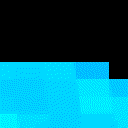

None


In [10]:
# thumbnails as a movie

@retry.Retry()
def get_display_movie(region, images):

  visParams = {
    'min': 0,
    'max': 0.0002,
    'palette': ['00FFFF', '0000FF']
    };
  url = images.getVideoThumbURL(visParams | {
      'region': region,
      'dimensions': '128x128',
      'format': 'gif',
      'bands': ['tropospheric_NO2_column_number_density']

  })

  r = requests.get(url, stream=True)
  if r.status_code != 200:
    raise google.api_core.exceptions.from_http_response(r)

  return r.content

display_movie = get_display_movie(TEST_ROI, images)
print(display(Image(display_movie)))


### Gallery of reduced image thumbnails over a region of interest

This section includes functions to obtain a time series of reduced image thumbnails for visualization as a image gallery  


In [13]:
# code courtesy https://mindtrove.info/


def gallery(images, row_height='auto'):
    """Shows a set of images in a gallery that flexes with the width of the notebook.

    Parameters
    ----------
    images: list of str or bytes
        URLs or bytes of images to display

    row_height: str
        CSS height value to assign to all images. Set to 'auto' by default to show images
        with their native dimensions. Set to a value like '250px' to make all rows
        in the gallery equal height.
    """

    def _src_from_data(data):
      """Base64 encodes image bytes for inclusion in an HTML img element"""
      img_obj = Image(data=data)
      for bundle in img_obj._repr_mimebundle_():
          for mimetype, b64value in bundle.items():
              if mimetype.startswith('image/'):
                  return f'data:{mimetype};base64,{b64value}'


    figures = []
    for image in images:
        if isinstance(image, bytes):
            src = _src_from_data(image)
            caption = ''
        else:
            src = image
            caption = f'<figcaption style="font-size: 0.6em">{image}</figcaption>'
        figures.append(f'''
            <figure style="margin: 5px !important;">
              <img src="{src}" style="height: {row_height}">
              {caption}
            </figure>
        ''')
    return HTML(data=f'''
        <div style="display: flex; flex-flow: row wrap; text-align: center;">
        {''.join(figures)}
        </div>
    ''')


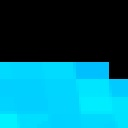
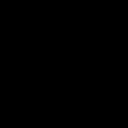
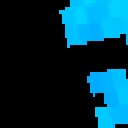
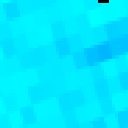
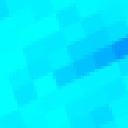
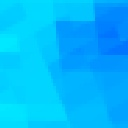
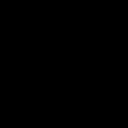
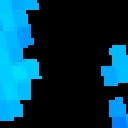
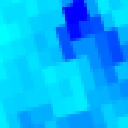
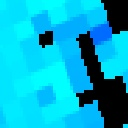
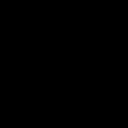
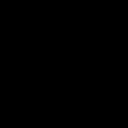
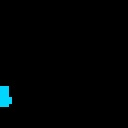
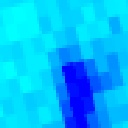
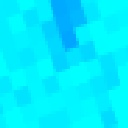
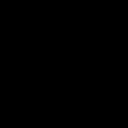
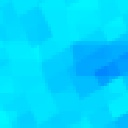
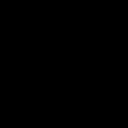
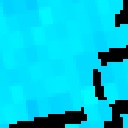
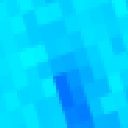
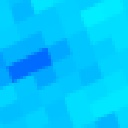
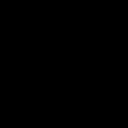
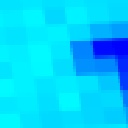
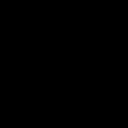
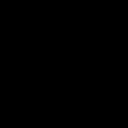
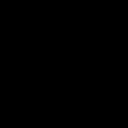
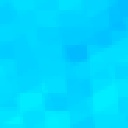
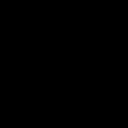
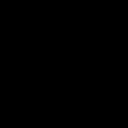
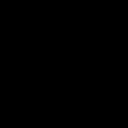
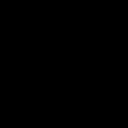
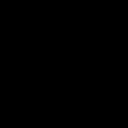

In [15]:


@retry.Retry()
def get_display_image(region, image):
    """Helper to display a patch using notebook widgets."""

    visParams = {
    'min': 0,
    'max': 0.0002,
    'palette': ['00FFFF', '0000FF']
    };
    url = image.getThumbURL(visParams | {
        'region': region,
        'dimensions': '128x128',
        'format': 'jpg',
        'bands': ['tropospheric_NO2_column_number_density']

    })

    r = requests.get(url, stream=True)
    if r.status_code != 200:
      raise google.api_core.exceptions.from_http_response(r)

    return r.content


# number of images to display
images_list = images.toList(images.size())
display_images = []
for index in range(images_list.size().getInfo()):
  image = ee.Image(images_list.get(index))
  time = image.date().format().getInfo()
  # print(time)
  display_images.append(get_display_image(TEST_ROI, image))


gallery(display_images)



### Gallery of reduced image band array data  over a region of interest

This section includes functions to obtain a time series of reduced image band array data for visualization as a image gallery  


Obtain image patches using computePixels over the region of interest

In [16]:
# Output resolution in meters. nominal scale is 1113.2 meters for Sentine-5p data

SCALE = 1113.2

# Pre-compute a geographic coordinate system.
proj = ee.Projection('EPSG:4326').atScale(SCALE).getInfo()
PATCH_SIZE = 32. # 32 sq km
# Get scales in degrees out of the transform.
SCALE_X = proj['transform'][0]
SCALE_Y = -proj['transform'][4]

# Offset to the upper left corner.
OFFSET_X = -SCALE_X * PATCH_SIZE / 2
OFFSET_Y = -SCALE_Y * PATCH_SIZE / 2

# Request template.
REQUEST = {
      'fileFormat': 'NPY',
      'grid': {
          'dimensions': {
              'width': PATCH_SIZE,
              'height': PATCH_SIZE
          },
          'affineTransform': {
              'scaleX': SCALE_X,
              'shearX': 0,
              'shearY': 0,
              'scaleY': SCALE_Y,
          },
          'crsCode': proj['crs']
      }
  }

@retry.Retry()
def get_patch(coords, image):
  """Get a patch centered on the coordinates, as a numpy array."""
  request = dict(REQUEST)
  request['expression'] = image
  request['grid']['affineTransform']['translateX'] = coords[0] + OFFSET_X
  request['grid']['affineTransform']['translateY'] = coords[1] + OFFSET_Y
  return np.load(io.BytesIO(ee.data.computePixels(request)))



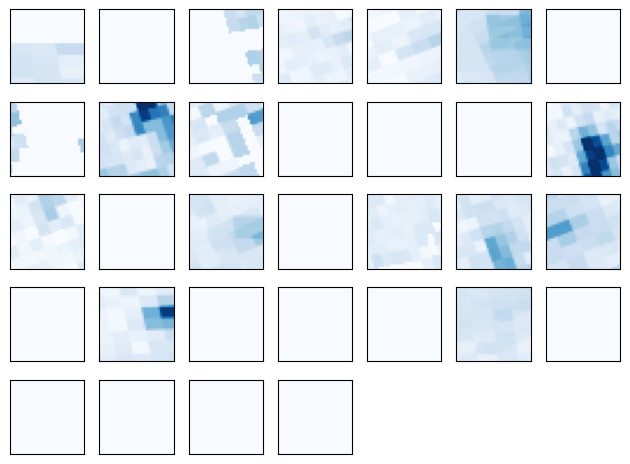

In [17]:

# number of images to display
images_list = images.toList(images.size())
cols = 7
rows = math.ceil(images_list.size().getInfo()/cols)

fig = plt.figure()
for index in range(images_list.size().getInfo()):
  image = ee.Image(images_list.get(index))
  time = image.date().format().getInfo()
  np_array = get_patch(TEST_COORDS, image)
  ax = fig.add_subplot(rows, cols, index+1)
  display_array = rfn.structured_to_unstructured(np_array[['tropospheric_NO2_column_number_density']])
  plt.imshow(display_array, cmap='Blues', vmin=0.0, vmax= 0.0002)
  ax.axes.xaxis.set_ticks([])
  ax.axes.yaxis.set_ticks([])
plt.tight_layout()
plt.show()

### Daily time series of spatially averaged statistics over the reduced images for charting

Based on [demo notebook](https://colab.research.google.com/github/google/earthengine-community/blob/master/guides/linked/Earth_Engine_training_patches_computePixels.ipynb#scrollTo=o6FH8sIlHElY)

In [18]:
# from the computePixels demo
# Define a function (and embedded function) for reducing a region for charting
# See the function descriptions defined in red within the functions

def create_reduce_region_function(geometry,
                                  reducer=ee.Reducer.median(),
                                  scale=1113.2,
                                  crs='EPSG:4326',
                                  bestEffort=True,
                                  maxPixels=1e13,
                                  tileScale=4):
  """Creates a region reduction function.

  Creates a region reduction function intended to be used as the input function
  to ee.ImageCollection.map() for reducing pixels intersecting a provided region
  to a statistic for each image in a collection. See ee.Image.reduceRegion()
  documentation for more details.

  """

  def reduce_region_function(img):
    """
      Function returns
      An ee.Feature that contains properties representing the image region
      reduction results per band and the image timestamp formatted as
      milliseconds from Unix epoch (included to enable time series plotting).
    """

    stat = img.reduceRegion(
        reducer=reducer,
        geometry=geometry,
        scale=scale,
        crs=crs,
        bestEffort=bestEffort,
        maxPixels=maxPixels,
        tileScale=tileScale)

    return ee.Feature(geometry, stat).set({'millis': img.date().millis()})
  return reduce_region_function

In [19]:
# Use the above defined function to create a reducing function specific to our data in
# order to extract the time series of interest

REDUCER = ee.Reducer.median()\
  .combine(reducer2 = ee.Reducer.mean(),sharedInputs=True)\
  .combine(reducer2 = ee.Reducer.count(),sharedInputs=True)

reduced_bandnames = ee.List(['tropospheric_NO2_column_number_density_count',
                            'tropospheric_NO2_column_number_density_mean',
                            'tropospheric_NO2_column_number_density_median'])

reduce_NO2 = create_reduce_region_function(
    geometry=TEST_ROI, reducer=REDUCER)

# Convert the image collection to a feature collection
NO2_stat_fc = ee.FeatureCollection(images.map(reduce_NO2))


# Filter out null values based on bandnames of the first image in the feature collection

NO2_stat_fc = NO2_stat_fc.filter(ee.Filter.notNull(reduced_bandnames))

In [20]:
import pandas as pd

def fc_to_dict(fc):
  prop_names = fc.first().propertyNames()
  prop_lists = fc.reduceColumns(
      reducer=ee.Reducer.toList().repeat(prop_names.size()),
      selectors=prop_names).get('list')

  return ee.Dictionary.fromLists(prop_names, prop_lists)


NO2_stat_dict = fc_to_dict(NO2_stat_fc).getInfo()

# Conversion of dictionary to dataframe for pandas usage for both years
NO2_stat_df = pd.DataFrame(NO2_stat_dict)

def add_date_info(df):
  df['Timestamp'] = pd.to_datetime(df['millis'], unit='ms')
  df['Date'] = pd.DatetimeIndex(df['Timestamp']).date
  return df

NO2_stat_df = add_date_info(NO2_stat_df).drop(columns=['millis', 'system:index'])

NO2_stat_df

,tropospheric_NO2_column_number_density_count,tropospheric_NO2_column_number_density_mean,tropospheric_NO2_column_number_density_median,Timestamp,Date
0,833,0.000031,0.000032,2023-01-01,2023-01-01
1,454,0.000050,0.000050,2023-01-03,2023-01-03
2,1679,0.000018,0.000016,2023-01-04,2023-01-04
3,1683,0.000015,0.000011,2023-01-05,2023-01-05
4,1683,0.000054,0.000052,2023-01-06,2023-01-06
5,510,0.000056,0.000055,2023-01-08,2023-01-08
6,1683,0.000059,0.000041,2023-01-09,2023-01-09
7,1352,0.000030,0.000022,2023-01-10,2023-01-10
8,20,0.000033,0.000033,2023-01-13,2023-01-13
9,1683,0.000055,0.000034,2023-01-14,2023-01-14
